In [1]:
!python --version


Python 3.9.21


In [2]:
# !pip install tensorflow==2.13.0 numpy==1.23.5



In [3]:
import numpy as np
import tensorflow as tf

In [4]:
# !pip install pandas 


In [5]:
# pip install opencv-python

In [6]:
# !pip install scikit-learn


In [7]:
# !pip install matplotlib

In [8]:
import pandas as pd
import os
import cv2
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [9]:
meta = pd.read_csv('dataset/archive/metadata.csv')
print(len(meta))
meta.head()

95634


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [10]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

,dtypes,count,unique,missing#,missing%
videoname,object,95634,95634,0,0.000000
original_width,int64,95634,31,0,0.000000
original_height,int64,95634,34,0,0.000000
label,object,95634,2,0,0.000000
original,object,79341,16955,16293,0.170368


In [11]:
print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))

Fake Images: 79341
Real Images: 16293


In [12]:
real_df = meta[meta['label'] == 'REAL'].sample(16000, random_state=42)
fake_df = meta[meta['label'] == 'FAKE'].sample(16000, random_state=42)
sample_meta = pd.concat([real_df, fake_df])

In [13]:
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

In [14]:
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, label) in zip(set_name['videoname'], set_name['label']):
        img_path = 'dataset/archive/faces_224/' + img[:-4] + '.jpg'
        img = cv2.imread(img_path)
        if img is None:
            continue
        images.append(img)
        labels.append(1 if label == 'FAKE' else 0)
    return np.array(images), np.array(labels)

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
batch_size = 16
preprocess = tf.keras.applications.efficientnet.preprocess_input

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(lambda x, y: (preprocess(tf.cast(x, tf.float32)), y)).shuffle(1000).batch(batch_size).prefetch(1)

valid_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
valid_set = valid_set.map(lambda x, y: (preprocess(tf.cast(x, tf.float32)), y)).batch(batch_size)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(lambda x, y: (preprocess(tf.cast(x, tf.float32)), y)).batch(batch_size)

In [16]:
# base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: Freeze base
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#               loss="binary_crossentropy",
#               metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [17]:
print("Training top classifier layers...")
model.fit(train_set, validation_data=valid_set, epochs=3)
model.save('fine_tuned_efficientnet.h5')

Training top classifier layers...
Epoch 1/3
1120/1120 [==============================] - 674s 600ms/step - loss: 0.6560 - accuracy: 0.6093 - val_loss: 0.6473 - val_accuracy: 0.6246
Epoch 2/3
1120/1120 [==============================] - 493s 440ms/step - loss: 0.6328 - accuracy: 0.6441 - val_loss: 0.6450 - val_accuracy: 0.6241
Epoch 3/3
1120/1120 [==============================] - 1355s 1s/step - loss: 0.6232 - accuracy: 0.6535 - val_loss: 0.6287 - val_accuracy: 0.6445


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fine-tune top layers only
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Fine-tune
model.fit(train_set,
          validation_data=valid_set,
          epochs=10,
          callbacks=[early_stop])


Epoch 1/10
1120/1120 [==============================] - 508s 451ms/step - loss: 0.6150 - accuracy: 0.6653 - val_loss: 0.6308 - val_accuracy: 0.6447
Epoch 2/10
1120/1120 [==============================] - 484s 433ms/step - loss: 0.6104 - accuracy: 0.6681 - val_loss: 0.6309 - val_accuracy: 0.6452
Epoch 3/10
1120/1120 [==============================] - 488s 436ms/step - loss: 0.6123 - accuracy: 0.6653 - val_loss: 0.6318 - val_accuracy: 0.6448
Epoch 4/10
1120/1120 [==============================] - 485s 433ms/step - loss: 0.6131 - accuracy: 0.6632 - val_loss: 0.6321 - val_accuracy: 0.6441


In [ ]:
# base_model.trainable = True  # Unfreeze entire base or select top layers if needed

# # Recompile with lower LR
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               loss="binary_crossentropy",
#               metrics=["accuracy"])

In [ ]:
# # Fine-tune entire model
# print("Fine-tuning full model...")
# model.fit(train_set, validation_data=valid_set, epochs=5)

In [15]:
print("Extracting feature vectors for PGM")

# Extract features from the layer before the Dense output
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

def extract_features(dataset):
    features = []
    labels = []
    for images, batch_labels in dataset:
        feats = feature_extractor.predict(images, verbose=0)
        features.extend(feats)
        labels.extend(batch_labels.numpy())
    return np.array(features), np.array(labels)

X_train_feats, y_train_feats = extract_features(train_set)
X_val_feats, y_val_feats = extract_features(valid_set)
X_test_feats, y_test_feats = extract_features(test_set)

Extracting feature vectors for PGM


In [16]:
np.save('X_train_feats.npy', X_train_feats)
np.save('y_train_feats.npy', y_train_feats)
np.save('X_val_feats.npy', X_val_feats)
np.save('y_val_feats.npy', y_val_feats)
np.save('X_test_feats.npy', X_test_feats)
np.save('y_test_feats.npy', y_test_feats)

print("Feature extraction completed")
print(f"Train features shape: {X_train_feats.shape}")
print(f"Validation features shape: {X_val_feats.shape}")
print(f"Test features shape: {X_test_feats.shape}")

Feature extraction completed
Train features shape: (17920, 1792)
Validation features shape: (7680, 1792)
Test features shape: (6400, 1792)


In [17]:
X_train_feats = np.load('X_train_feats.npy')
y_train_feats = np.load('y_train_feats.npy')

print("Feature vector for image 0:")
print(X_train_feats[0])
print("Label (0=REAL, 1=FAKE):", y_train_feats[0])


Feature vector for image 0:
[ 0.0402723  -0.182949    0.14076233 ... -0.25903133 -0.199129
 -0.20841065]
Label (0=REAL, 1=FAKE): 0


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 12.720457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.075867
[t-SNE] KL divergence after 1000 iterations: 1.828938


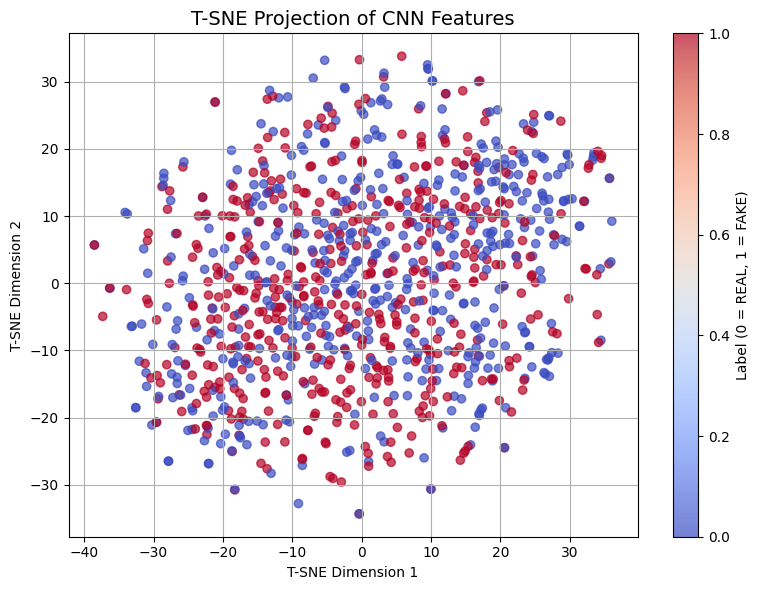

In [21]:

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# 2. Load extracted features

# Make sure you have already saved these in Phase 1
X_train_feats = np.load("X_train_feats.npy")
y_train_feats = np.load("y_train_feats.npy")


# 3. Subsample for efficiency
# t-SNE is computationally expensive — limit to 1000 points
N = 1000
X_sample = X_train_feats[:N]
y_sample = y_train_feats[:N]

# 4. Feature normalization
# Standardizing improves t-SNE performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)


# 5. Run T-SNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            n_iter=1000, random_state=42, verbose=1)
X_tsne = tsne.fit_transform(X_scaled)


# 6. Plot T-SNE projection

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap="coolwarm", alpha=0.7)
plt.title("T-SNE Projection of CNN Features", fontsize=14)
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.colorbar(scatter, label='Label (0 = REAL, 1 = FAKE)')
plt.grid(True)
plt.tight_layout()
plt.show()


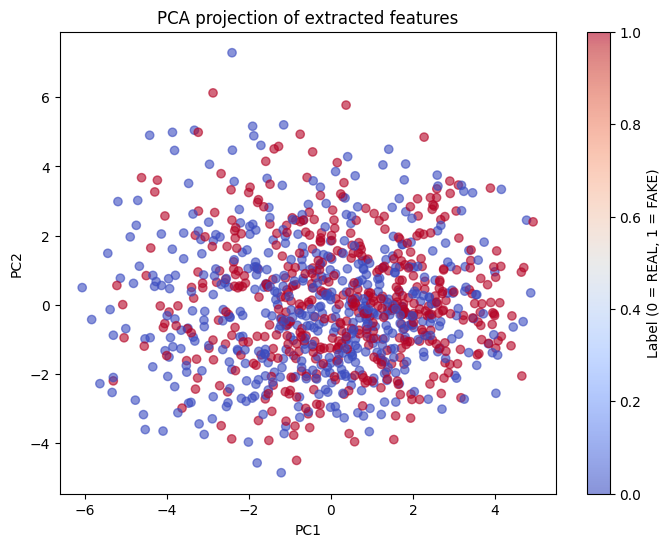

In [19]:
from sklearn.decomposition import PCA

X = X_train_feats[:1000].astype(np.float32)
y = y_train_feats[:1000]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title('PCA projection of extracted features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Label (0 = REAL, 1 = FAKE)')
plt.show()

In [31]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 33.8 MB/s eta 0:00:0000:0100:01


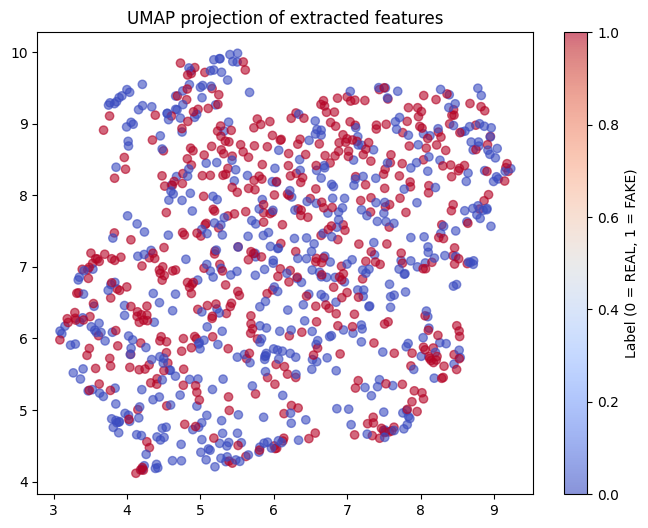

In [20]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

X = X_train_feats[:1000].astype(np.float32)
y = y_train_feats[:1000]

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("UMAP projection of extracted features")
plt.colorbar(label='Label (0 = REAL, 1 = FAKE)')
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_feats, y_train_feats)
preds = clf.predict(X_val_feats)

print(classification_report(y_val_feats, preds))
print("AUC:", roc_auc_score(y_val_feats, clf.predict_proba(X_val_feats)[:, 1]))


              precision    recall  f1-score   support

           0       0.70      0.72      0.71      3840
           1       0.71      0.70      0.71      3840

    accuracy                           0.71      7680
   macro avg       0.71      0.71      0.71      7680
weighted avg       0.71      0.71      0.71      7680

AUC: 0.7751628960503473


In [36]:
# !pip install cmake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 32.5 MB/s eta 0:00:0000:0100:01


In [37]:
# !pip install dlib

  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp39-cp39-macosx_13_0_arm64.whl size=3066295 sha256=aab2fa2977a92d6a9253a13093afe2c82b9943422878ccd2126931eeb75df9f6
  Stored in directory: /Users/lanchidinh/Library/Caches/pip/wheels/f5/ba/ea/ad13d4a963e5dbbbaf4dce5fef93353e2e7586ba8b7787221c
Successfully built dlib


In [38]:
# !pip install face_recognition

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0-py2.py3-none-any.whl
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)


In [9]:
import face_recognition
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

# Reuse base EfficientNetB4 for region-level feature extraction
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
region_feature_model = Model(inputs=base_model.input, outputs=x)
# Just reuse your fine-tuned model from Phase 1
# region_feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Define facial regions to extract
REGIONS = ['left_eye', 'right_eye', 'nose_bridge', 'top_lip', 'bottom_lip']

In [44]:
# # ✅ Use output of the penultimate layer (before final Dense sigmoid)
# # Make sure to re-train and save this using model.save('fine_tuned_efficientnet.h5') if needed
# fine_tuned_model = tf.keras.models.load_model("fine_tuned_efficientnet.h5")

# # ✅ Use output of the penultimate layer (before final Dense sigmoid)
# region_feature_model = Model(inputs=fine_tuned_model.input,
#                              outputs=fine_tuned_model.layers[-2].output)  # shape (1792,)

# # ✅ Define facial regions to extract
# REGIONS = ['left_eye', 'right_eye', 'nose_bridge', 'top_lip', 'bottom_lip']

# -------------------------------
# 🧩 Helper: Crop & Resize Region
# -------------------------------
# def crop_and_resize_region(image, region_points):
#     if not region_points:
#         return None
#     xs, ys = zip(*region_points)
#     x_min, x_max = max(min(xs)-5, 0), min(max(xs)+5, image.shape[1])
#     y_min, y_max = max(min(ys)-5, 0), min(max(ys)+5, image.shape[0])
#     cropped = image[y_min:y_max, x_min:x_max]
#     if cropped.size == 0:
#         return None
#     return cv2.resize(cropped, (224, 224))

# # -------------------------------
# # 🧩 Helper: Extract local CNN features from all regions
# # -------------------------------
# def extract_local_features(image):
#     if image.dtype != np.uint8:
#         image = image.astype(np.uint8)

#     landmarks_list = face_recognition.face_landmarks(image)
#     if not landmarks_list:
#         print("⚠️ No face detected.")
#         return None

#     landmarks = landmarks_list[0]
#     all_feats = []

#     for region in REGIONS:
#         if region not in landmarks:
#             print(f"⚠️ Region not found: {region}")
#             return None

#         region_img = crop_and_resize_region(image, landmarks[region])
#         if region_img is None:
#             print(f"⚠️ Region crop failed: {region}")
#             return None

#         region_input = preprocess_input(region_img.astype(np.float32))
#         region_input = np.expand_dims(region_input, axis=0)

#         feat = region_feature_model.predict(region_input, verbose=0).flatten()
#         all_feats.append(feat)

#     return np.concatenate(all_feats)


# # -------------------------------
# # 🔄 Run on Subset of Dataset
# # -------------------------------
# X_train_local, y_train_local = [], []

# for i, (img, label) in enumerate(zip(X_train, y_train)):
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)

#     try:
#         local_feat = extract_local_features(img_rgb)
#         if local_feat is not None:
#             X_train_local.append(local_feat)
#             y_train_local.append(label)

#             if len(X_train_local) <= 5:
#                 print(f"[✅ Preview] Sample {i}, Label: {label}, Feature shape: {local_feat.shape}")
#         else:
#             print(f"[⛔ Skipped] Sample {i}, no features.")
#     except Exception as e:
#         print(f"[❌ Error] Sample {i} — {str(e)}")


# # Convert to numpy arrays
# X_train_local = np.array(X_train_local)
# y_train_local = np.array(y_train_local)

# # Save features
# np.save("X_train_local_feats.npy", X_train_local)
# np.save("y_train_local_labels.npy", y_train_local)
# print("✅ Saved region-based CNN features from fine-tuned model")
# print("Shape:", X_train_local.shape)


[✅ Preview] Sample 0, Label: 1, Feature shape: (8960,)
[✅ Preview] Sample 1, Label: 0, Feature shape: (8960,)
⚠️ No face detected.
[⛔ Skipped] Sample 2, no features.
[✅ Preview] Sample 3, Label: 0, Feature shape: (8960,)
⚠️ No face detected.
[⛔ Skipped] Sample 4, no features.
[✅ Preview] Sample 5, Label: 1, Feature shape: (8960,)
⚠️ No face detected.
[⛔ Skipped] Sample 6, no features.
[✅ Preview] Sample 7, Label: 1, Feature shape: (8960,)
⚠️ No face detected.
[⛔ Skipped] Sample 11, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 14, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 26, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 29, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 30, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 36, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 38, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 46, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 56, no features.
⚠️ No face detected.
[⛔ Skipped] Sample 63, 

KeyboardInterrupt: 

In [10]:
def crop_and_resize_region(image, region_points):
    if not region_points:
        return None
    xs, ys = zip(*region_points)
    x_min, x_max = max(min(xs)-5, 0), min(max(xs)+5, image.shape[1])
    y_min, y_max = max(min(ys)-5, 0), min(max(ys)+5, image.shape[0])
    cropped = image[y_min:y_max, x_min:x_max]
    if cropped.size == 0:
        return None
    return cv2.resize(cropped, (224, 224))

def extract_local_features(image):
    landmarks_list = face_recognition.face_landmarks(image)
    if not landmarks_list:
        return None
    landmarks = landmarks_list[0]
    all_feats = []
    for region in REGIONS:
        if region not in landmarks:
            return None
        region_img = crop_and_resize_region(image, landmarks[region])
        if region_img is None:
            return None
        region_input = preprocess_input(region_img.astype(np.float32))
        region_input = np.expand_dims(region_input, axis=0)
        feat = region_feature_model.predict(region_input, verbose=0).flatten()
        all_feats.append(feat)
    return np.concatenate(all_feats)

In [11]:
X_train_local, y_train_local = [], []

# For debugging: visualize region crops
def visualize_landmark_regions(image):
    landmarks_list = face_recognition.face_landmarks(image)
    if not landmarks_list:
        print("No landmarks detected.")
        return
    landmarks = landmarks_list[0]
    fig, axs = plt.subplots(1, len(REGIONS), figsize=(15, 3))
    for i, region in enumerate(REGIONS):
        if region not in landmarks:
            axs[i].set_title(f"{region}\nNot Found")
            axs[i].axis('off')
            continue
        region_img = crop_and_resize_region(image, landmarks[region])
        if region_img is not None:
            axs[i].imshow(region_img)
            axs[i].set_title(region)
            axs[i].axis('off')
    plt.tight_layout()
    plt.show()

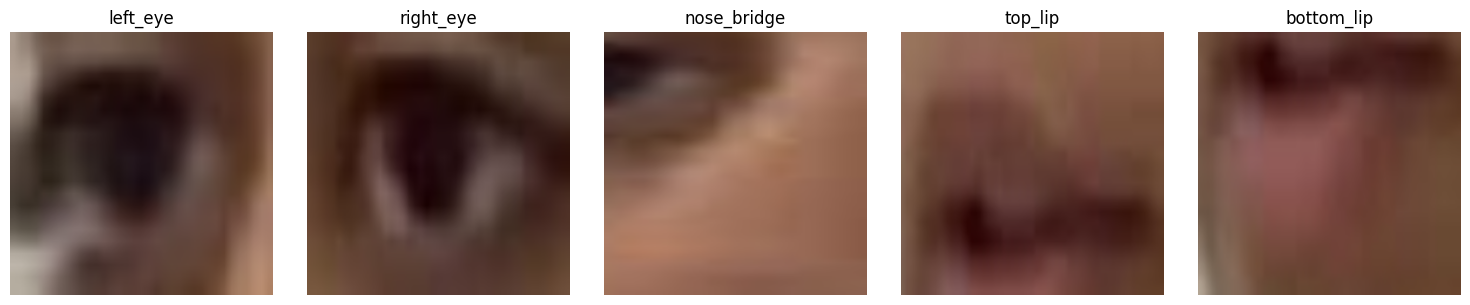

In [17]:
img_example = X_train[500]  # change index as needed
img_example_rgb = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)
visualize_landmark_regions(img_example_rgb)

In [18]:
sample_indices = np.random.choice(len(X_train), size=500, replace=False)
X_train_sample = [X_train[i] for i in sample_indices]
y_train_sample = [y_train[i] for i in sample_indices]

[Preview] Sample 0, Label: 0


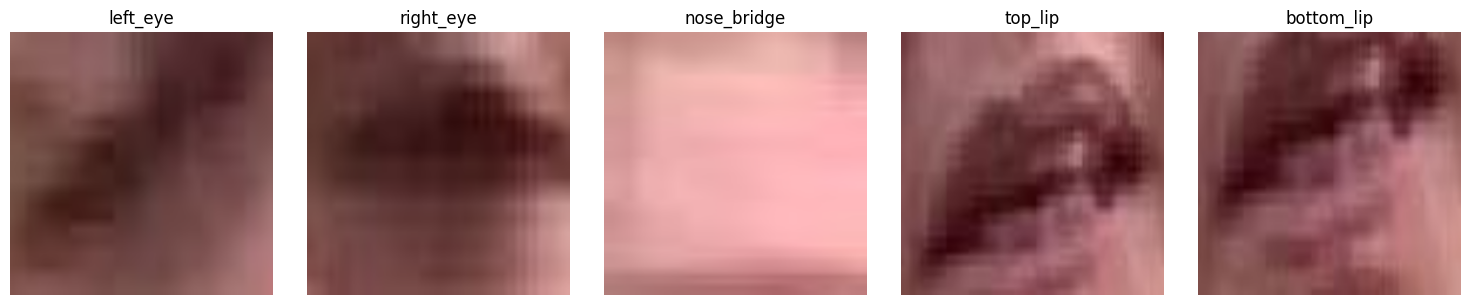

[Preview] Sample 1, Label: 1


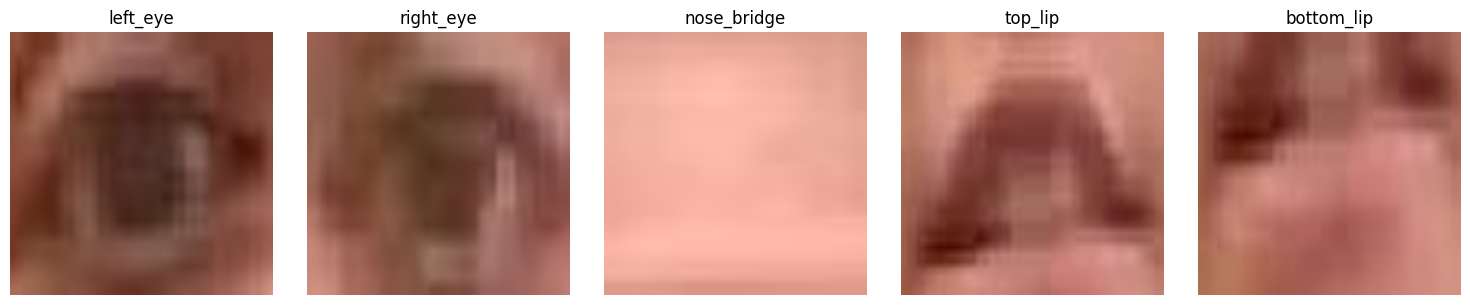

[Preview] Sample 2, Label: 1


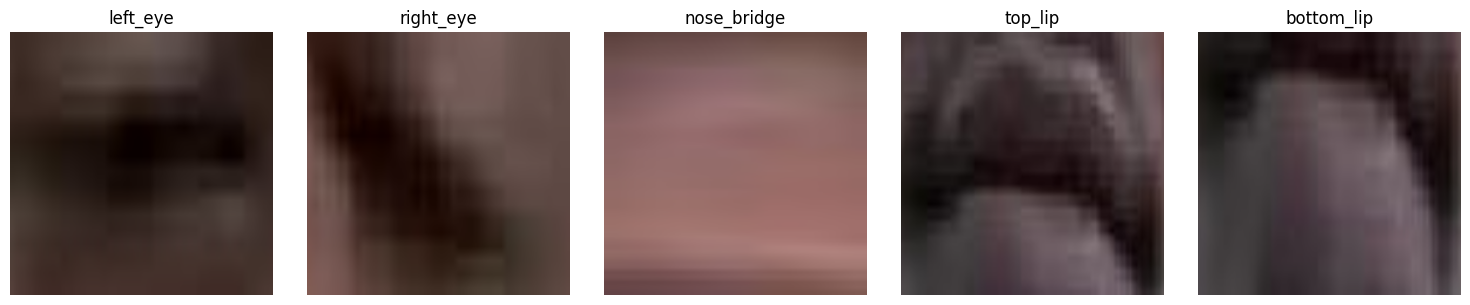

[Preview] Sample 3, Label: 0


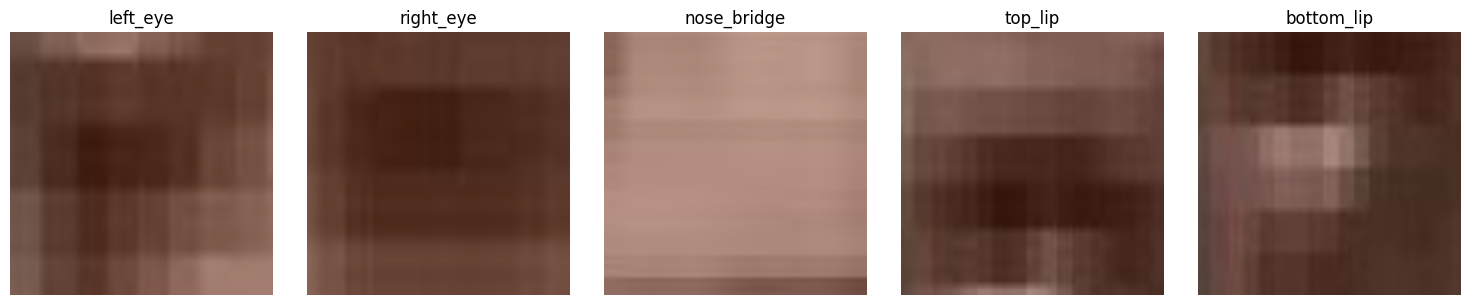

[Preview] Sample 4, Label: 1


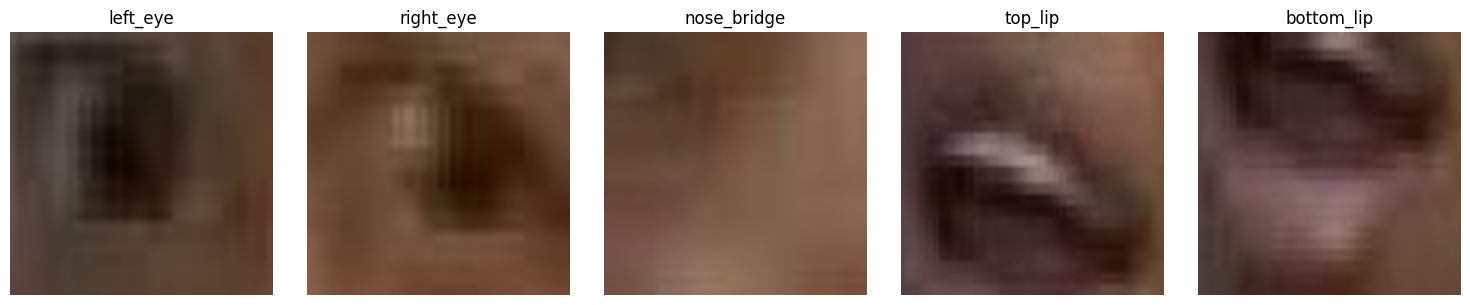

In [19]:

for i, (img, label) in enumerate(zip(X_train_sample, y_train_sample)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    local_feat = extract_local_features(img_rgb)
    if local_feat is not None:
        X_train_local.append(local_feat)
        y_train_local.append(label)

        if len(X_train_local) <= 5:
            print(f"[Preview] Sample {i}, Label: {label}")
            visualize_landmark_regions(img_rgb)

In [20]:
X_train_local = np.array(X_train_local)
y_train_local = np.array(y_train_local)

np.save("X_train_local_feats.npy", X_train_local)
np.save("y_train_local_labels.npy", y_train_local)

print("Saved region-based features for PGM input")
print("Shape:", X_train_local.shape)


Saved region-based features for PGM input
Shape: (419, 8960)


In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Load region-based CNN features
X = np.load("X_train_local_feats.npy")  # shape: (404, 8960)
y = np.load("y_train_local_labels.npy")

# Train/test split (e.g., 80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_proba))


              precision    recall  f1-score   support

           0       0.65      0.55      0.59        44
           1       0.57      0.68      0.62        40

    accuracy                           0.61        84
   macro avg       0.61      0.61      0.61        84
weighted avg       0.61      0.61      0.61        84

AUC: 0.6227272727272727


### Draft

In [50]:
from pomegranate import *
# from pomegranate import DiscreteDistribution, ConditionalProbabilityTable
# from pomegranate.bayesian_network import BayesianNetwork
from sklearn.preprocessing import KBinsDiscretizer
# from pomegranate import Node, State
# region-based features and labels
X_train_local = np.load("X_train_local_feats.npy")
y_train_local = np.load("y_train_local_labels.npy")

In [51]:
# discretize the features to categorical values (for BN)
n_bins = 3  # or 2 for binary features
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
X_disc = discretizer.fit_transform(X_train_local)


In [52]:
# create feature names for regions (we had 5 regions, each outputting 1792-dim EfficientNetB4)
n_regions = 5
region_names = ['left_eye', 'right_eye', 'nose', 'top_lip', 'bottom_lip']

# reduce each region to a single categorical feature using PCA or mean
region_feats = []
region_dim = X_train_local.shape[1] // n_regions
for i in range(n_regions):
    region_i = X_disc[:, i * region_dim:(i + 1) * region_dim]
    region_feats.append(region_i.mean(axis=1).astype(int))  # reduce to one categorical var per region

# final data matrix: 5 regions + 1 label (deepfake)
data = np.stack(region_feats + [y_train_local], axis=1)
data = data.astype(int)

In [58]:
from pomegranate import DiscreteDistribution, ConditionalProbabilityTable, Node, State, BayesianNetwork


ImportError: cannot import name 'DiscreteDistribution' from 'pomegranate' (/Users/lanchidinh/anaconda3/envs/myenv39/lib/python3.9/site-packages/pomegranate/__init__.py)

In [59]:
import pomegranate
print(pomegranate.__version__)


1.1.2


In [60]:
from pomegranate.distributions import DiscreteDistribution, ConditionalProbabilityTable
from pomegranate.bayesian_network import BayesianNetwork
from pomegranate import Node, State


ImportError: cannot import name 'DiscreteDistribution' from 'pomegranate.distributions' (/Users/lanchidinh/anaconda3/envs/myenv39/lib/python3.9/site-packages/pomegranate/distributions/__init__.py)

In [54]:
# define distributions for each region
dists = [DiscreteDistribution.from_samples(data[:, i]) for i in range(5)]

# define conditional distribution for target: P(is_deepfake | all 5 regions)
cpt_data = np.column_stack([data[:, i] for i in range(6)])  # 5 features + label
cpt = ConditionalProbabilityTable.from_samples(cpt_data, [*dists])


NameError: name 'pomegranate' is not defined